# Тестирование классификатора эмоций

В этом ноутбуке описано тестирование модели, а также подготовка файла для Kaggle

In [1]:
import pandas as pd
import numpy as np
import os

import random

In [2]:
# флаг использования Google drive как хранилища данных
USE_GOOGLE_DRIVE = False

#Корневая папка проекта
root_dir = ''

In [3]:
#Подключаем google drive, если код будет выполняться в Colab
if USE_GOOGLE_DRIVE:
    from google.colab import drive

    drive.mount('/content/drive')
    root_dir = '/content/drive/My Drive/Projects/EmoDetector'
    
    import sys
    sys.path.append(root_dir)

#if

In [4]:
import emo_utils as utils
import emo_classificator_model as ecm

In [5]:
#Получаем пути к директориям и файлам проекта

paths = utils.get_paths()

print (paths)

{'data_dir': 'data', 'model_dir': 'model', 'train_data_dir': 'data/train', 'train_aug_data_dir': 'data/train_aug', 'val_data_dir': 'data/val', 'test_data_dir': 'data/test_kaggle', 'class_names_path': 'data/class_names.txt', 'best_checkpoint_path': 'model/emo_classificator_best'}


In [6]:
#загрузим названия эмоций (классов)
emo_classes_names = []
with open(paths['class_names_path'], 'r') as f:
    emo_classes_names = f.read().split(',')
    
emo_classes_names

['anger',
 'contempt',
 'disgust',
 'fear',
 'happy',
 'neutral',
 'sad',
 'surprise',
 'uncertain']

In [7]:
#Путь к сохраненной модели
model_path = paths['model_dir'] + '/emo_classificator_best_210106100147_xception_e20_aug1_acc44.h5'

In [8]:
#Создадим классификатор эмоций
base_model_names = ['resnet50', 'vgg16', 'xception']

#тип базовой модели
base_model = None
for model_name in base_model_names:
    if model_path.find(model_name) > -1:
        base_model = model_name
        break
    #if

emo_classifier = ecm.EmoClassifier (model_path, base_model, emo_classes_names)

In [9]:
#Соберем пути до изображений и индексы эмоций

folder = []    
for i in os.walk(paths['train_data_dir']):
    folder.append(i)

images_paths = []
images_labels = []
for i in folder:
    for j in i[2]:
        images_paths.append(i[0]+'/'+j)
        images_labels.append(emo_classes_names.index(i[0].split('/')[-1]))    
    #for

# выберем картинки для проверки
sample_cnt = 16

sample_img_paths = []
sample_img_labels = []
for i in range (sample_cnt):
    index = random.choice(range(0, len(images_paths)))
    sample_img_paths.append (images_paths[index])
    sample_img_labels.append (images_labels[index])
    
#for

print (sample_img_paths)
print (sample_img_labels)

['data/train/anger/4265.jpg', 'data/train/disgust/257.jpg', 'data/train/sad/3844.jpg', 'data/train/disgust/1039.jpg', 'data/train/anger/3480.jpg', 'data/train/contempt/1968.jpg', 'data/train/anger/2341.jpg', 'data/train/sad/173.jpg', 'data/train/neutral/430.jpg', 'data/train/anger/5077.jpg', 'data/train/neutral/620.jpg', 'data/train/anger/1262.jpg', 'data/train/anger/1526.jpg', 'data/train/sad/6002.jpg', 'data/train/anger/4267.jpg', 'data/train/neutral/4973.jpg']
[0, 2, 6, 2, 0, 1, 0, 6, 5, 0, 5, 0, 0, 6, 0, 5]


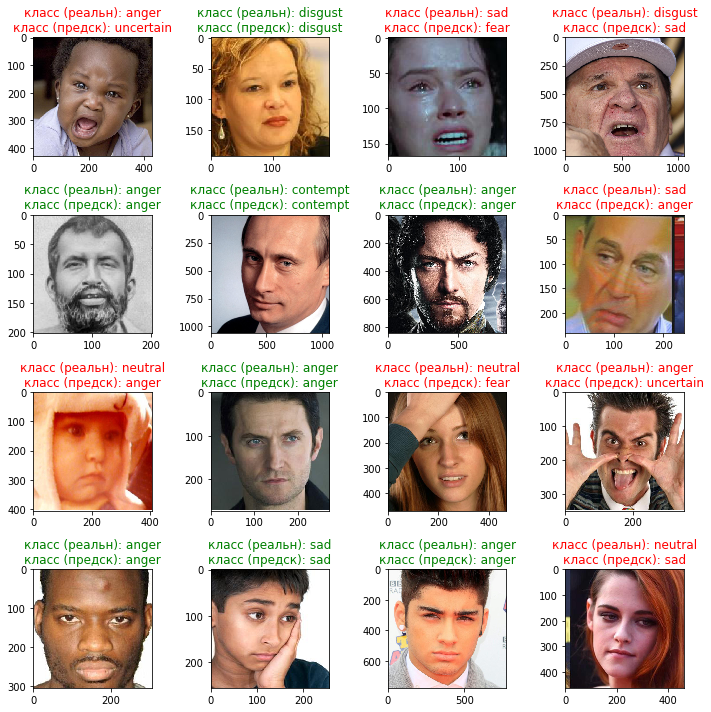

In [11]:
#Тест модели

utils.test_model_prediction (p_model = emo_classifier.model,
                             p_img_paths = sample_img_paths,
                             p_img_emo_idxs = sample_img_labels,
                             p_img_target_size = (emo_classifier.image_size, emo_classifier.image_size),
                             preprocess_func = emo_classifier.preprocess_input_func,
                             p_emo_classes_names = emo_classes_names)

## Получение файла для проверки модели на Kaggle

In [12]:
#Загрузим перечень картинок для теста

test_images = []

for root, dirs, files in os.walk(paths['test_data_dir']):
    test_images = files
    break

#for
   
print (test_images)

['3994.jpg', '389.jpg', '2135.jpg', '691.jpg', '1910.jpg', '4607.jpg', '2572.jpg', '4091.jpg', '3305.jpg', '2579.jpg', '1005.jpg', '2922.jpg', '426.jpg', '4590.jpg', '514.jpg', '873.jpg', '4174.jpg', '720.jpg', '1513.jpg', '835.jpg', '1353.jpg', '4504.jpg', '1403.jpg', '3937.jpg', '494.jpg', '951.jpg', '4918.jpg', '133.jpg', '1491.jpg', '166.jpg', '436.jpg', '2040.jpg', '2717.jpg', '1758.jpg', '3762.jpg', '4909.jpg', '3503.jpg', '2807.jpg', '4678.jpg', '2306.jpg', '711.jpg', '3161.jpg', '3586.jpg', '3912.jpg', '3398.jpg', '653.jpg', '2700.jpg', '4007.jpg', '3596.jpg', '3879.jpg', '414.jpg', '4490.jpg', '652.jpg', '3626.jpg', '250.jpg', '1357.jpg', '3348.jpg', '395.jpg', '2702.jpg', '4764.jpg', '3814.jpg', '2798.jpg', '214.jpg', '713.jpg', '4813.jpg', '1749.jpg', '392.jpg', '2772.jpg', '4554.jpg', '4720.jpg', '4325.jpg', '4827.jpg', '4611.jpg', '3263.jpg', '1903.jpg', '461.jpg', '908.jpg', '479.jpg', '958.jpg', '3014.jpg', '441.jpg', '1284.jpg', '4219.jpg', '3130.jpg', '633.jpg', '3084.

In [16]:
#Формируем файл для проверки на kaggle

target_img_size = (emo_classifier.image_size, emo_classifier.image_size)

df = pd.DataFrame(columns = ['image_path', 'emotion', 'image_id'])

for img_file in test_images:

    preprocessed_img = utils.preprocess_image(paths['test_data_dir']+'/'+img_file, 
                                              target_img_size, 
                                              emo_classifier.preprocess_input_func)
    #получим предсказания
    #predictions = model_emo_classificator.predict(preprocessed_img)
    
    file_name, _ = os.path.splitext(img_file)
    image_id = int(file_name)
    
    df = df.append ({'image_path': img_file, 
                     #'emotion': emo_classes_names[np.argmax(predictions)], emo_classifier.
                     'emotion': emo_classifier.predict (preprocessed_img),
                     'image_id': image_id}, ignore_index=True) 
#for
    
df = df.sort_values('image_id')
df = df.drop('image_id', axis=1)

df.to_csv(paths['data_dir']+'/' + os.path.basename(model_path).replace('.h5','.csv'), index = False)

df

,image_path,emotion
2131,0.jpg,sad
2594,1.jpg,neutral
1784,2.jpg,sad
2728,3.jpg,anger
1282,4.jpg,neutral
...,...,...
4637,4995.jpg,surprise
1701,4996.jpg,fear
4592,4997.jpg,neutral
3400,4998.jpg,sad
